In [1]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'parking-lot-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F87490%2F201391%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240717%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240717T093240Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D7bf7d9a21d55777de2e00633f148bd627dbb7c5076be6388d9c1382d8edfb8c50f74f35112c23eba2e26a14c0d7552157d944ecc7f3da5081461c925ed2f3770d8e41053e6e4edf3244e89c627055032bc0be31654b88a6cf85a93eb50eb2989a95dcb8d0e021c65bbaa60d6ae41ef0eda2d2fbe7b8db3374c82298681508525b18e7a2e30069609933640afdb74df380c9a6e7254b7cfedfc86e5606e3d016686226ffdcc179ded029596191c4d3ae3e2a6032fd7238263473fbd2066ca88d6f14fd46b5c59580934959c80958bc10eaf64899aa7a4d257e4183b23268b30edf72011624df29615e2025937a74d856e12a2030fdd643d032ade30b3f8a6c48d'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 10720116108 bytes downloaded
Downloaded and uncompressed: parking-lot-dataset
Data source import complete.


In [4]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#Khởi tạo kích thước đầu vào của hình ảnh
input_shape = (100,100,3)

x_train = np.ndarray((1, 100, 100, 3))
y_train = np.ndarray((1, 2))
x_val = np.ndarray((1, 100, 100, 3))
y_val = np.ndarray((1, 2))


for folder_name in os.listdir('/kaggle/input/parking-lot-dataset/PKLot/PKLotSegmented/PUC/Cloudy'):
    train_dir = f"/kaggle/input/parking-lot-dataset/PKLot/PKLotSegmented/PUC/Cloudy/{folder_name}"
    num_classes = 2
#Thiết lập một ImageDataGenerator với các tham số tăng cường
    augment_datagen = ImageDataGenerator(
            rescale=1./255,
            shear_range=0.1,
            rotation_range=20,
            zoom_range=0.1,
            horizontal_flip=True,
            vertical_flip=True,
            validation_split=0.2)

# Tải hình ảnh vào các thư mục riêng biệt dựa trên nhãn lớp
    train_generator = augment_datagen.flow_from_directory(
            train_dir,
            shuffle=True,
            seed=42,
            target_size=input_shape[:2],
            batch_size=256,
            class_mode='categorical',
            subset='training')

    validation_generator = augment_datagen.flow_from_directory(
            train_dir,
            target_size=input_shape[:2],
            batch_size=256,
            shuffle=True,
            seed=42,
            class_mode='categorical',
            subset='validation')

    x_tr, y_tr = next(train_generator)
    x_v, y_v = next(validation_generator)

    x_val = np.append(x_val, x_v, axis=0)
    y_val = np.append(y_val, y_v, axis=0)

    x_train = np.append(x_train, x_tr[:500], axis=0)
    y_train = np.append(y_train, y_tr[:500], axis=0)

Found 12399 images belonging to 2 classes.
Found 3099 images belonging to 2 classes.
Found 12321 images belonging to 2 classes.
Found 3079 images belonging to 2 classes.
Found 4079 images belonging to 2 classes.
Found 1019 images belonging to 2 classes.
Found 10559 images belonging to 2 classes.
Found 2638 images belonging to 2 classes.
Found 6321 images belonging to 2 classes.
Found 1579 images belonging to 2 classes.
Found 11920 images belonging to 2 classes.
Found 2980 images belonging to 2 classes.
Found 801 images belonging to 2 classes.
Found 199 images belonging to 2 classes.
Found 10799 images belonging to 2 classes.
Found 2699 images belonging to 2 classes.
Found 11598 images belonging to 2 classes.
Found 2898 images belonging to 2 classes.
Found 12481 images belonging to 2 classes.
Found 3119 images belonging to 2 classes.
Found 12955 images belonging to 2 classes.
Found 3238 images belonging to 2 classes.


In [6]:
#cắt bỏ phần tử đầu tiên của các mảng x_train, y_train, x_val, y_val
x_train = x_train[1:]
y_train = y_train[1:]
x_val = x_val[1:]
y_val = y_val[1:]

In [7]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import shuffle
import numpy as np

#Tạo mẫu ngẫu nhiên
rus = RandomUnderSampler(random_state=42)

#Chuyển đổi hình ảnh từ 4D sang 2D
n_samples, height, width, depth = x_train.shape
x_train_2d = x_train.reshape((n_samples, height * width * depth))
x_train_resampled, y_train_resampled = rus.fit_resample(x_train_2d, y_train)
x_train_resampled, y_train_resampled = shuffle(x_train_resampled, y_train_resampled, random_state=42)

# Định hình lại dữ liệu đã lấy mẫu lại về hình dạng ban đầu
x_train = x_train_resampled.reshape((-1, height, width, depth))


print('Balanced training data shape:', x_train.shape, y_train_resampled.shape)


Balanced training data shape: (2146, 100, 100, 3) (2146, 1)


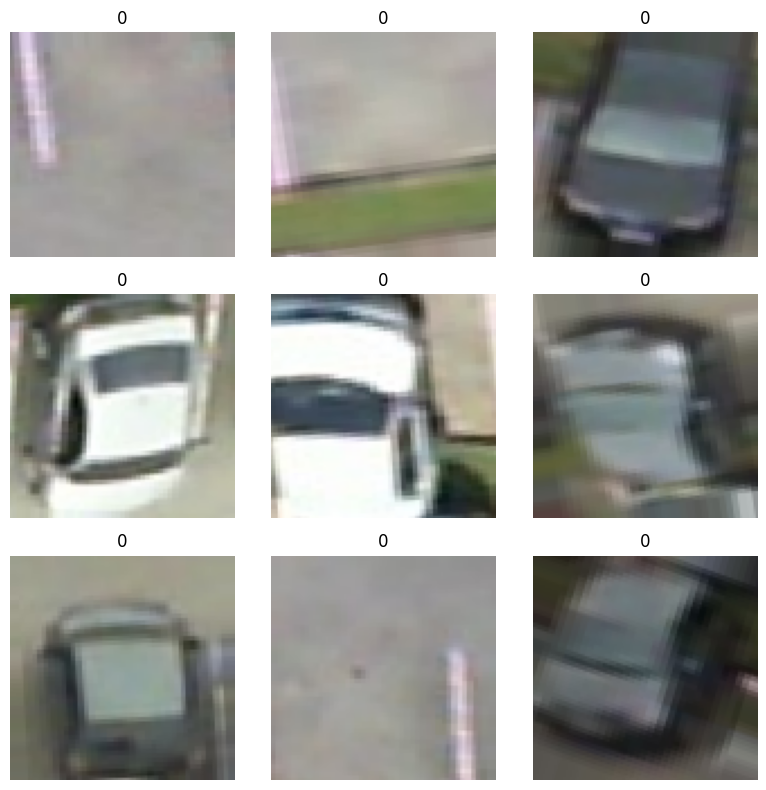

In [8]:
#Kiểm tra dữ liệu từ dữ liệu vừa chuyển đổi
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8, 8))

for i, ax in enumerate(axes.flat):
    ax.imshow(x_train[i+12])
    ax.set_title(np.argmax(y_train_resampled[i+12]))
    ax.axis('off')

plt.tight_layout()
plt.show()

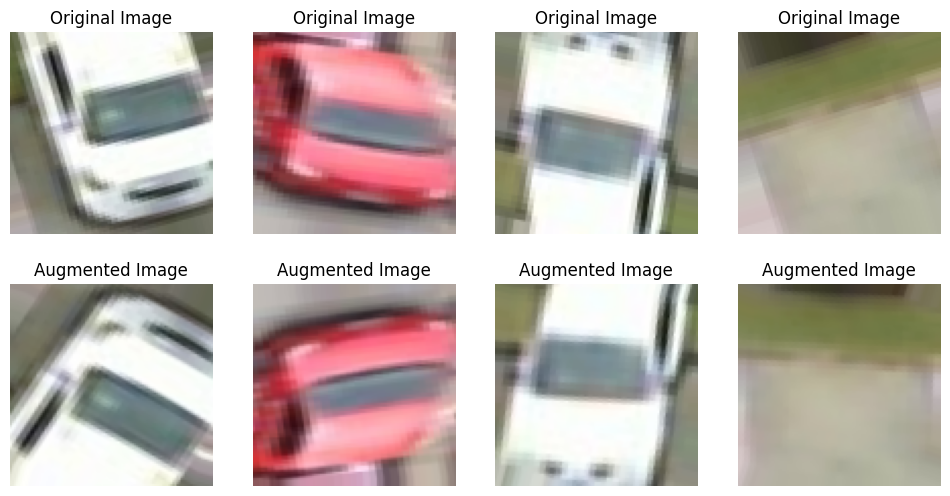

In [9]:
#Xuất ra hình ảnh chưa xử lý và xử lý rồi để so sánh
#Lấy lô ảnh đầu tiên từ trình tạo ảnh và cấu hình ảnh ở dạng (256,100,100)
batch = train_generator.next()
images = batch[0]
images = images.reshape((256, 100, 100, 3))

import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

for i in range(4):
    axes[0, i].imshow(images[i])
    axes[0, i].axis('off')
    axes[0, i].set_title('Original Image')

    transformed_img = augment_datagen.random_transform(images[i])
    axes[1, i].imshow(transformed_img)
    axes[1, i].axis('off')
    axes[1, i].set_title('Augmented Image')

plt.show()

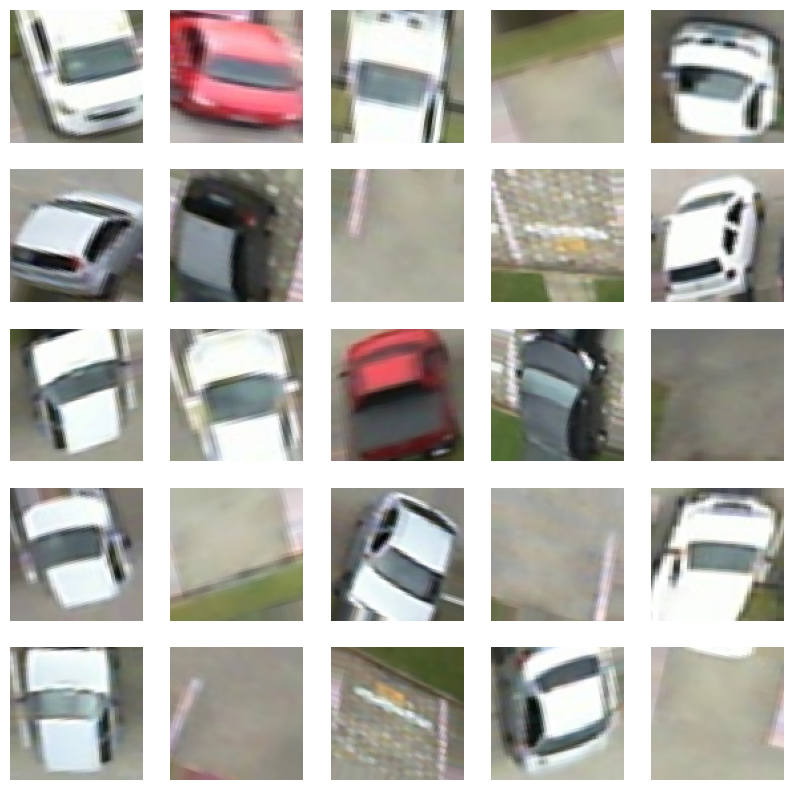

In [10]:
import matplotlib.pyplot as plt
#Xuất dữ liệu từ các hình ảnh đã được cắt để kiểm tr
fig, axes = plt.subplots(5, 5, figsize=(10, 10))

for i in range(25):
    row_idx = i // 5
    col_idx = i % 5
    axes[row_idx, col_idx].imshow(images[i])
    axes[row_idx, col_idx].axis('off')

plt.savefig('images_matrix.png')
plt.show()

In [11]:
import xml.etree.ElementTree as ET
import cv2
import numpy as np
import os
#Trích xuất các vùng đậu xe từ một hình ảnh dựa trên thông tin được cung cấp trong một tệp XML
def extract_parking_spaces(image_path, xml_path, save_dir='cropped_images', display_results=True, return_contours=False):
    # Tải hình ảnh
    img = cv2.imread(image_path)
    img_contours = img.copy()
    # Tạo file XML
    tree = ET.parse(xml_path)
    root = tree.getroot()

    # Xác định danh sách lưu trữ ảnh đã cắt
    cropped_images = []
    contours = []
    # Xác định danh sách màu cho các contour
    colors = [(0, 0, 255), (0, 255, 0), (255, 0, 0)]

    #Tạo file lưu ảnh
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

#Phân tích tệp XML để trích xuất thông tin về các vùng đậu xe như hình chữ nhật xoay, contour, trung tâm, kích thước và góc
    for i, space in enumerate(root.iter('space')):
        # Trích xuất hình chữ nhật và contour đã xoay từ tệp XML
        rotated_rect = space.find('rotatedRect')
        contour = space.find('contour')
        center = rotated_rect.find('center')
        size = rotated_rect.find('size')
        angle = rotated_rect.find('angle')

        # Trích xuất các giá trị từ  XML
        cx, cy = int(center.attrib['x']), int(center.attrib['y'])
        w, h = int(size.attrib['w']), int(size.attrib['h'])
        angle_deg = float(angle.attrib['d'])

        #Xoay contour theo góc
        angle_rad = angle_deg * (3.14159 / 180)

        # Trích xuất các điểm từ contour
        pts = []
        for point in contour.iter('point'):
            x, y = int(point.attrib['x']), int(point.attrib['y'])
            pts.append((x, y))

        #Tạo một mask dựa trên thông tin contour và xoay theo góc
        mask = np.zeros(img.shape[:2], dtype=np.uint8)
        cv2.fillPoly(mask, [np.array(pts)], (255, 255, 255))

        M = cv2.getRotationMatrix2D((cx, cy), angle_deg, 1)
        rotated_mask = cv2.warpAffine(mask, M, (img.shape[1], img.shape[0]))

        # Sử dụng mask để cắt vùng quan tâm từ hình ảnh.
        cropped = cv2.bitwise_and(img, img, mask=rotated_mask)


        x, y, w, h = cv2.boundingRect(np.array(pts))

        roi = img[y:y+h, x:x+w]

        #Thay đổi kích thước vùng cắt được thành 100x100
        resized_roi = cv2.resize(roi, (100, 100))

        cropped_images.append(resized_roi)

        cv2.drawContours(img_contours, [np.array(pts)], 0, colors[i % len(colors)], 2)

        contours.append(np.array(pts))

    if display_results:
        plt.grid(linewidth=0)
        plt.imshow(img_contours)
        plt.show()

    # hiển thị hình ảnh kết quả với các contour
    cropped_images_array = np.array(cropped_images)

    contours = np.array(contours)

    if return_contours:
            return cropped_images_array, contours

    return cropped_images_array

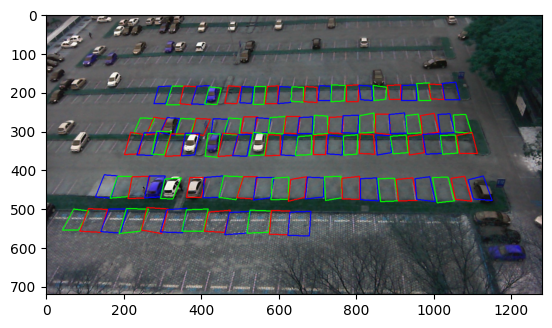

In [12]:
#Trích xuất các vùng đậu xe từ một hình ảnh dựa trên thông tin được cung cấp trong một tệp XML
image_path = '/kaggle/input/parking-lot-dataset/PKLot/PKLot/PUCPR/Cloudy/2012-09-12/2012-09-12_07_07_55.jpg'
xml_path = '/kaggle/input/parking-lot-dataset/PKLot/PKLot/PUCPR/Cloudy/2012-09-12/2012-09-12_07_07_55.xml'

res = extract_parking_spaces(image_path, xml_path, display_results=True)

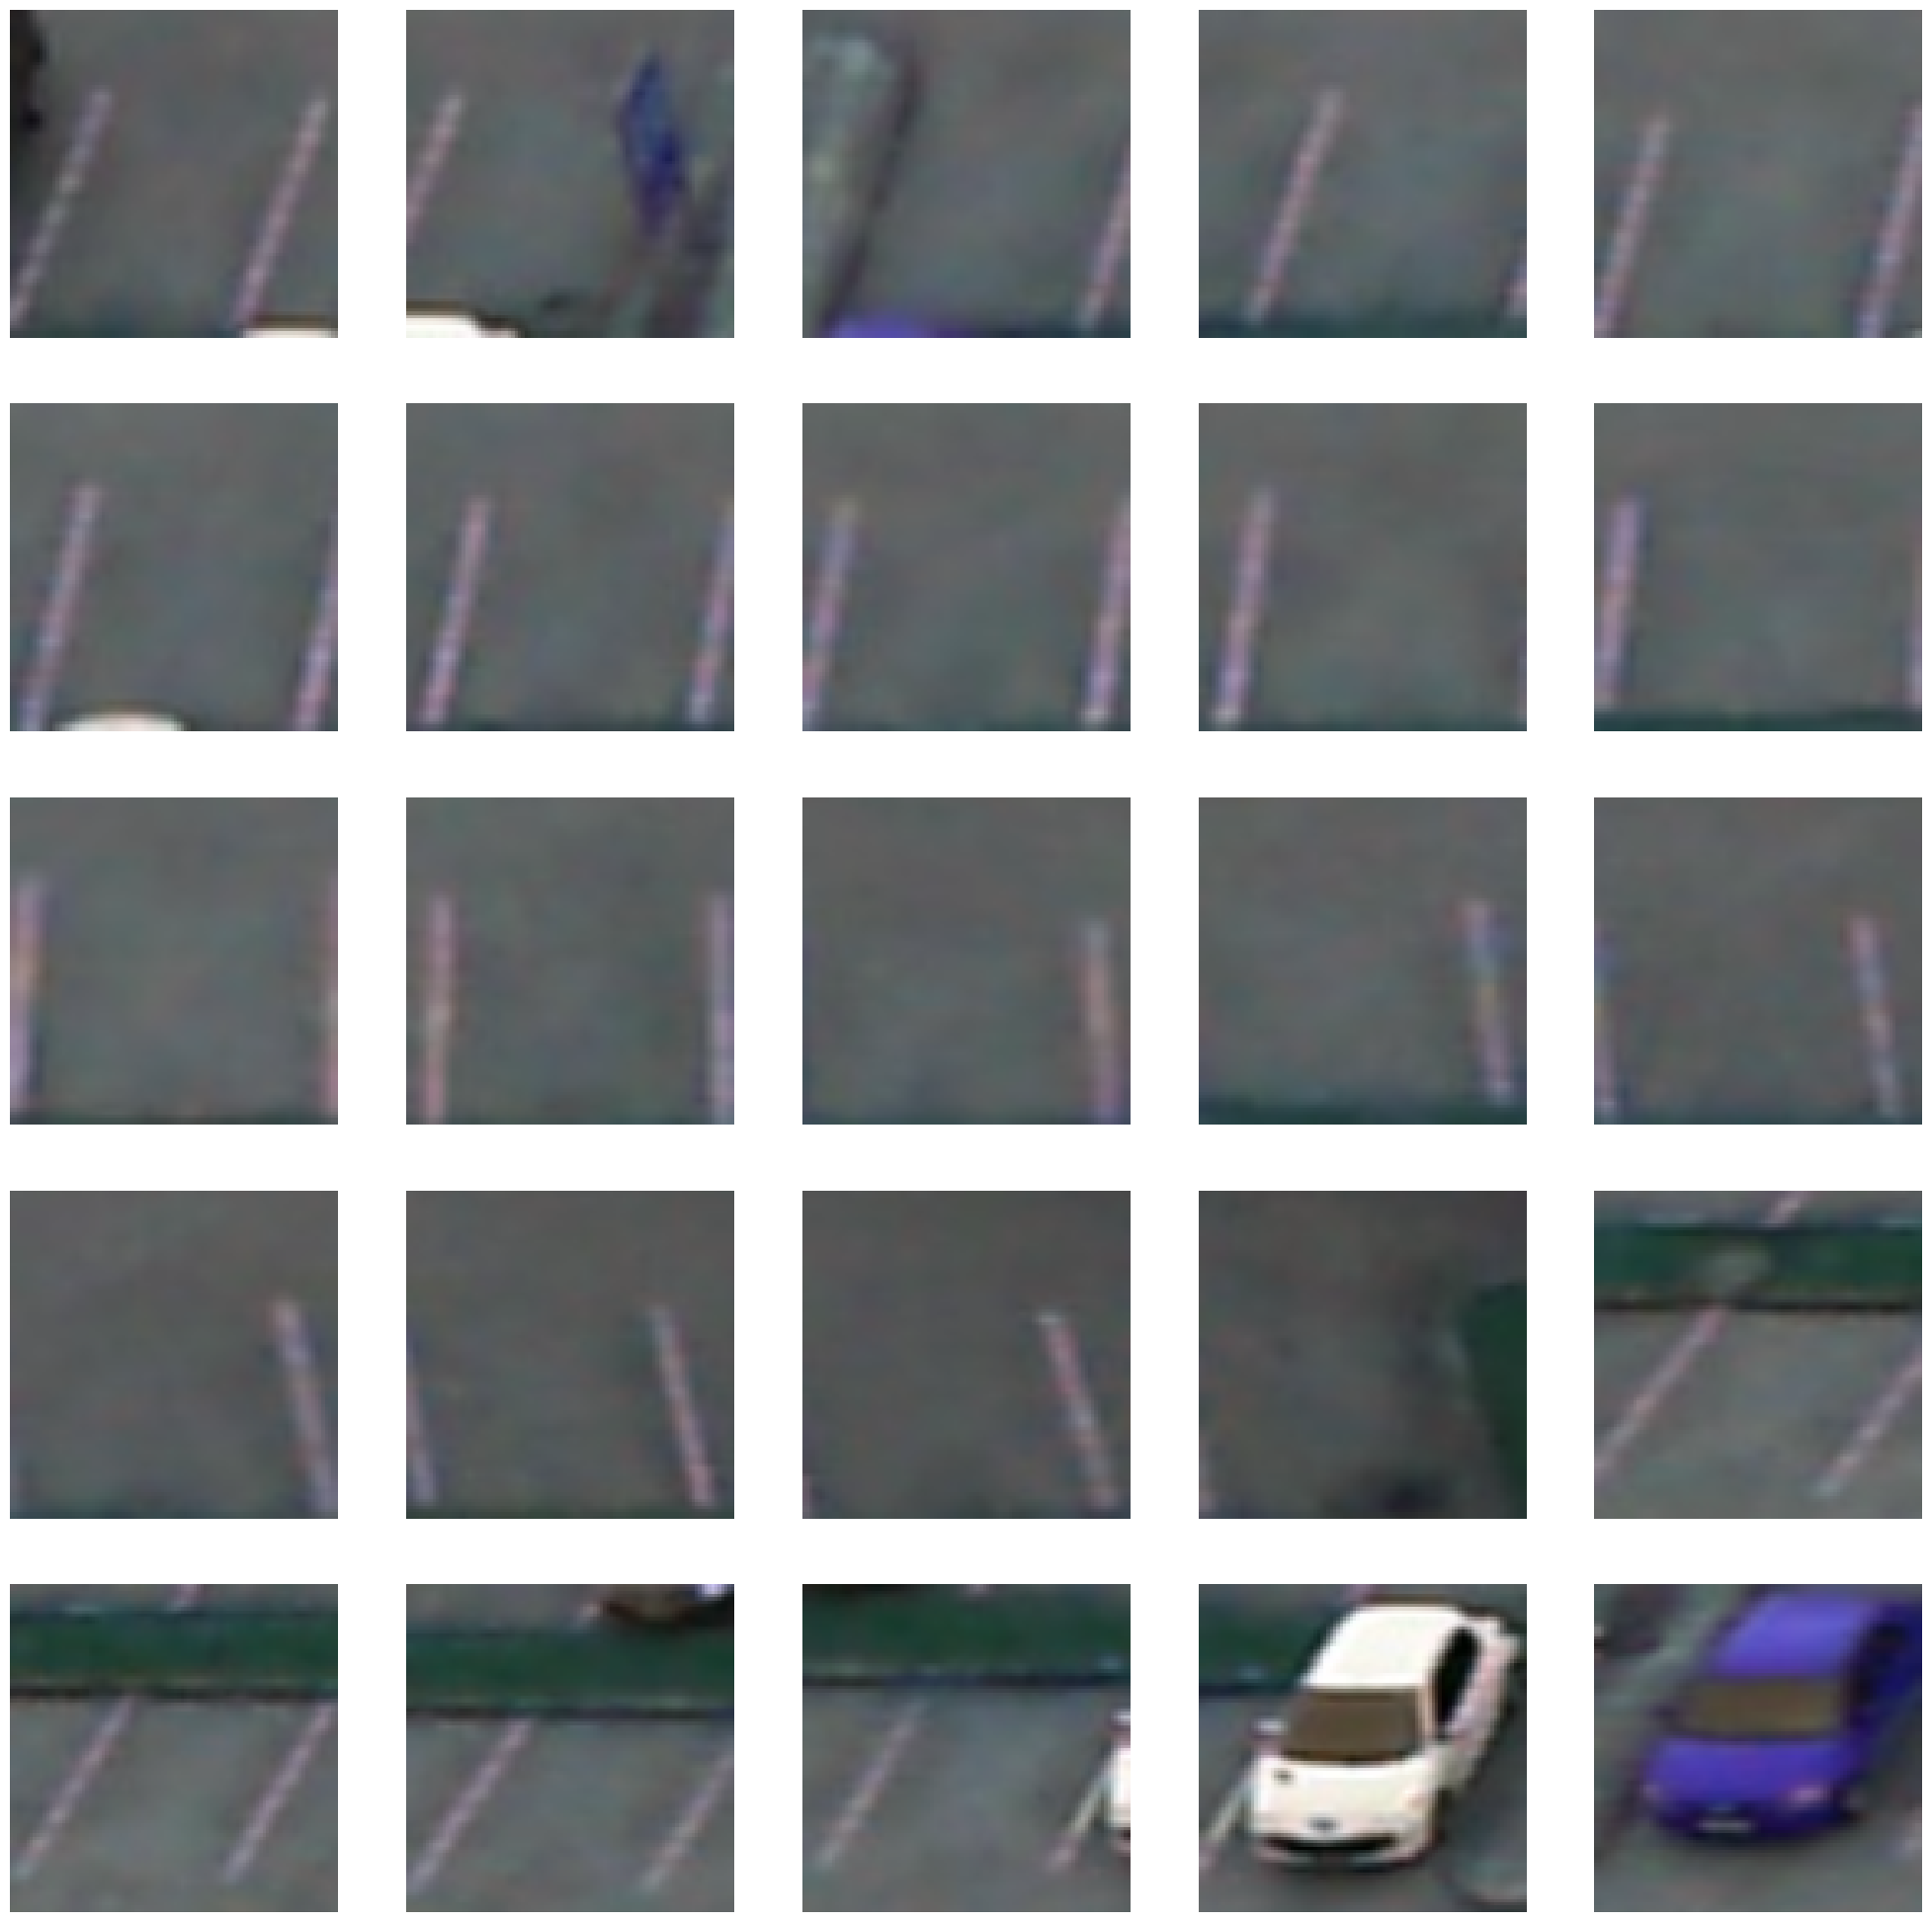

In [13]:
#Trích xuất các chỗ trống được cắt ra từ ảnh
fig, axs = plt.subplots(5, 5, figsize=(25, 25))
axs = axs.flatten()

for i in range(25):
    axs[i].imshow(res[i+25])
    axs[i].axis('off')

plt.show()

In [14]:
from keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping
from timeit import default_timer as timer
#Huấn luyện mô hình
class TimingCallback(Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

early_stopping = EarlyStopping(
                                patience=25,
                                min_delta = 0.01,
                                verbose=1,
                                mode = 'min',
                                monitor='val_loss')

reduce_learning_rate = ReduceLROnPlateau(
                                    monitor="val_loss",
                                    patience=10,
                                    episilon= 0.1,
                                    factor=0.1,
                                    cooldown = 2,
                                    verbose=1)

time_callback = TimingCallback()

# hyperparameters
lr = 0.001
batch_size = 256

Epoch 1/50
9/9 [==============================] - 4s 292ms/step - loss: 0.6767 - accuracy: 0.6938 - val_loss: 3.2349 - val_accuracy: 0.6386 - lr: 0.0010
Epoch 2/50
9/9 [==============================] - 1s 159ms/step - loss: 0.4939 - accuracy: 0.8281 - val_loss: 2.8439 - val_accuracy: 0.6390 - lr: 0.0010
Epoch 3/50
9/9 [==============================] - 1s 153ms/step - loss: 0.4114 - accuracy: 0.8663 - val_loss: 2.8037 - val_accuracy: 0.6404 - lr: 0.0010
Epoch 4/50
9/9 [==============================] - 2s 195ms/step - loss: 0.3545 - accuracy: 0.8928 - val_loss: 2.1329 - val_accuracy: 0.6491 - lr: 0.0010
Epoch 5/50
9/9 [==============================] - 2s 222ms/step - loss: 0.3274 - accuracy: 0.8970 - val_loss: 1.3347 - val_accuracy: 0.6839 - lr: 0.0010
Epoch 6/50
9/9 [==============================] - 2s 211ms/step - loss: 0.2961 - accuracy: 0.9101 - val_loss: 1.3769 - val_accuracy: 0.7075 - lr: 0.0010
Epoch 7/50
9/9 [==============================] - 1s 158ms/step - loss: 0.2800 - a

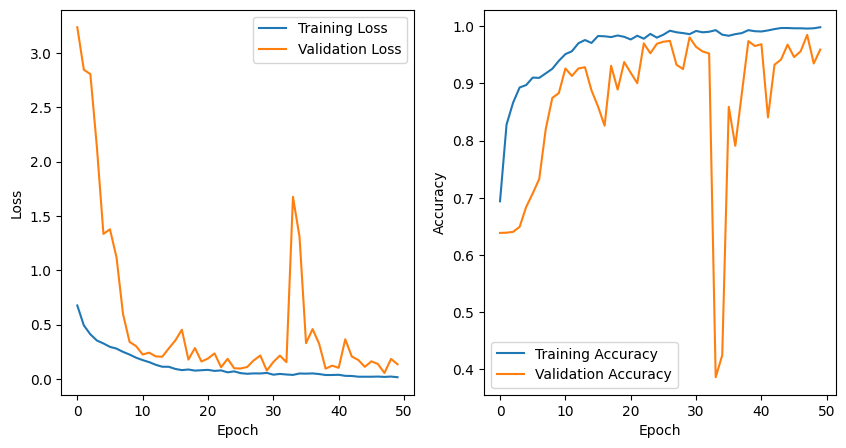

In [15]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.applications import ConvNeXtTiny, EfficientNetV2S
from tensorflow.keras.utils import plot_model
from keras.utils import to_categorical
from keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping
from timeit import default_timer as timer

# Gán hình ảnh 100x100
input_shape = (100, 100, 3)

base_model_convnext = ConvNeXtTiny(weights="imagenet", include_top=False, input_shape=input_shape)

for layer in base_model_convnext.layers:
    layer.trainable = False

# Thêm đầu phân loại vào mô hình
x = layers.GlobalAveragePooling2D()(base_model_convnext.output)
x = layers.Dense(units=256, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
outputs_convnext = layers.Dense(units=2, activation="softmax")(x)

# Xác định mô hình ConvNeXtTiny hoàn chỉnh
model_convnext = keras.Model(inputs=base_model_convnext.input, outputs=outputs_convnext)

# Tải mô hình EfficiencyNetV2S được đào tạo trước
base_model_efficientnet = EfficientNetV2S(weights="imagenet", include_top=False, input_shape=input_shape)

# Đóng băng trọng lượng của các lớp được huấn luyện trước
for layer in base_model_efficientnet.layers:
    layer.trainable = False

# Thêm đầu phân loại vào mô hình
x = layers.GlobalAveragePooling2D()(base_model_efficientnet.output)
x = layers.Dense(units=256, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
outputs_efficientnet = layers.Dense(units=2, activation="softmax")(x)

# Xác định mô hình EfficiencyNetV2S hoàn chỉnh
model_efficientnet = keras.Model(inputs=base_model_efficientnet.input, outputs=outputs_efficientnet)

#Tạo mô hình đơn giản
simple_model = keras.Sequential([
    layers.Flatten(input_shape=input_shape),
    layers.Dense(units=64, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(units=32, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(units=2, activation="softmax")
])
models = {'SimpleModel': simple_model,
        'EfficientNetV2S': model_efficientnet,
         'ConvNeXtTiny': model_convnext}

# Xác định số epoch và kích thước batch
epochs = 50
batch_size = 256

# Xác định optimizer and loss function
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.BinaryCrossentropy()


accuracy_dict = {}
y_train_resampled = to_categorical(y_train_resampled)

simple_model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=['accuracy']
)

# Huấn luyện mô hình
history = simple_model.fit(
    x_train, y_train_resampled,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_learning_rate, time_callback],
    verbose=1,
)


loss, accuracy = simple_model.evaluate(x_val, y_val)
print('Validation accuracy: {:.2f}%'.format(accuracy * 100))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [16]:
accuracy_df = pd.DataFrame.from_dict(accuracy_dict, orient='index', columns=['Accuracy'])

13/13 [==============================] - 14s 1s/step


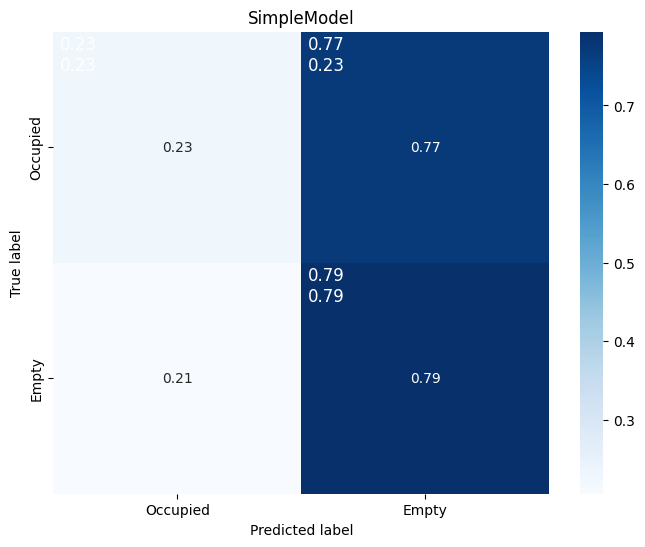

13/13 [==============================] - 224s 17s/step


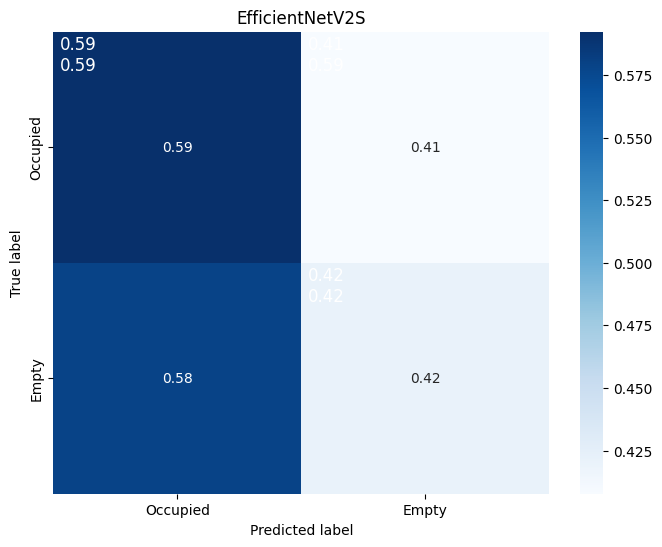

13/13 [==============================] - 1075s 81s/step


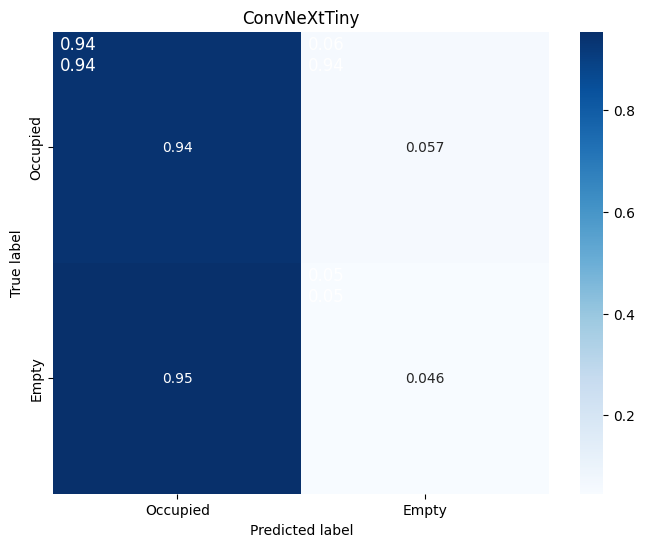

In [17]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Xác định các lớp
class_names = ['Occupied', 'Empty']

# Xác định hàm để vẽ ma trận nhầm lẫn đã chuẩn hóa
def plot_confusion_matrix(y_true, y_pred, title=''):
    # Tính ma trận nhầm lẫn
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    #Tính toán độ chính xác cho từng lớp
    acc_per_class = np.diag(cm_norm)

    # Vẽ ma trận nhầm lẫn
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_norm, annot=True, cmap=plt.cm.Blues, xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(title)

    for i, j in zip(*np.triu_indices_from(cm_norm)):
        plt.text(j+0.1, i+0.1, format(cm_norm[i, j], '.2f')+'\n'+format(acc_per_class[i], '.2f'), ha="center", va="center", color="white", fontsize=12)

    plt.show()

# Vẽ ma trận nhầm lẫn cho từng mô hình
for model_name, model in models.items():
    # Generate predictions on the validation data
    y_pred = np.argmax(model.predict(validation_generator), axis=1)
    y_true = validation_generator.classes

    plot_confusion_matrix(y_true, y_pred, title=model_name)


In [25]:
#trích xuất vị trí đỗ xe từ hình ảnh và thực hiện dự đoán với mô hình classifier nếu có
def make_predictions(image_path, xml_path, classifier=None, display_results=True):
    lots, contours = extract_parking_spaces(image_path, xml_path, display_results=True, return_contours=True)
    img = cv2.imread(image_path)
    if classifier is not None:
        for i, lot in enumerate(lots):
            # Sử dụng bộ phân loại để đưa ra dự đoán về hình ảnh đầu vào
            lot = np.expand_dims(lot, axis=0)
            prediction = classifier.predict(lot, verbose=0)
            prediction = np.argmax(prediction)

            # Vẽ một hộp màu xanh lá cây nếu nhãn bị chiếm, màu đỏ nếu không có nhãn
            color = (0, 255, 0) if prediction == 1 else (0, 0, 255)
            cv2.drawContours(img, [contours[i]], 0, color, 2)

    if display_results:
        plt.grid(linewidth=0)
        plt.imshow(img)
        plt.show()

In [26]:
image_path = '/kaggle/input/parking-lot-dataset/PKLot/PKLot/PUCPR/Cloudy/2012-09-12/2012-09-12_07_13_08.jpg'
xml_path = '/kaggle/input/parking-lot-dataset/PKLot/PKLot/PUCPR/Cloudy/2012-09-12/2012-09-12_07_13_08.xml'

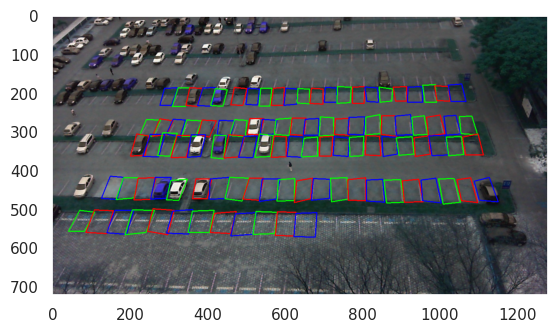

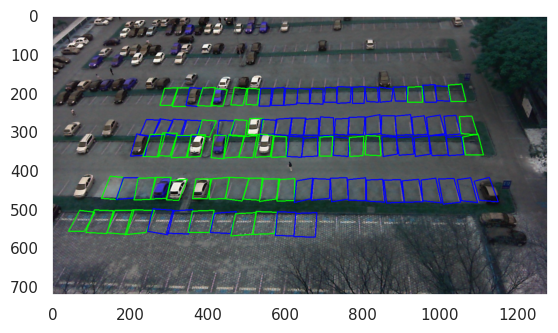

In [27]:
make_predictions(image_path, xml_path, classifier=models['SimpleModel'])